In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers.experimental.preprocessing import Normalization

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import MAPE
from tensorflow.keras.callbacks import EarlyStopping

#---Import moduls from stock-prediction package
from stock_prediction.data_prep import Data_Prep
from stock_prediction.features_exo import exo_selection

# Data exploration

In [4]:
def load_preproc_data(company='vinci'):
    """This function allows to load the data for chosen company,
    to select features make changes directly inside this function."""
    #---(1) Instantiate the Class 
    prep_class = Data_Prep(company, 252)



    #---(2) Load the first dataframe ready to use if no more modification
    df = prep_class.data_prep()



    #---(3) Function that allows us to delete some of the features we don't want to use for modelling 
    # Log Return is to False by default
    # *******************
    # if period < 252 , don't use Annual_vol
    #********************
    prep_class.select_features(df, Return = True, Log_Return=False, High_Low=False, High_Close=True, Low_Close=True,
                            Volume_Change=True, Period_Volum=True, Annual_Vol=True,
                            Period_Vol=True, Return_Index=True, Volum_Index=True, Relative_Return=True)

    #---(4) Function that add the exogenous features that you need to select 
    # returns the dataframe ready to modelling 
    # and the list of the columns to rebase it later - no VIX because no rebase for VIX - kept unchanged 
    df = exo_selection(df, sp500=True, gold=True, eurusd=True, nasdaq=True, crude=False, vix=True)

    #---(5) Sort values to make sure they are ordered *in case and drop data column
    df = df.sort_values('Date')
    df = df.drop(columns='Date')

    #---Company code on stock market
    idx = df.columns[0][7:]
    
    return df, idx

In [5]:
data, idx = load_preproc_data('vinci')

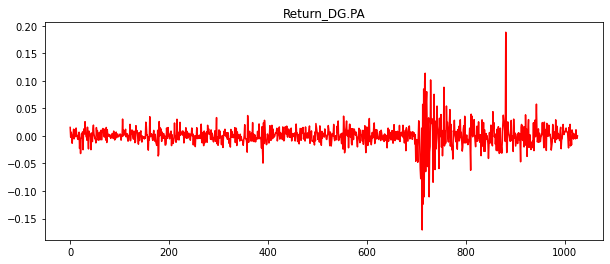

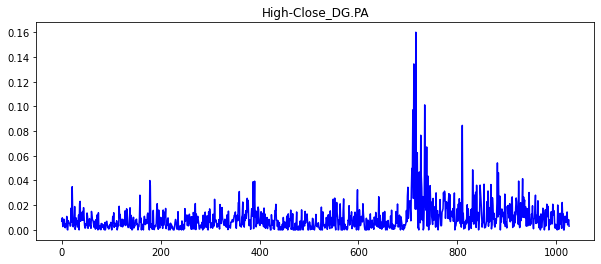

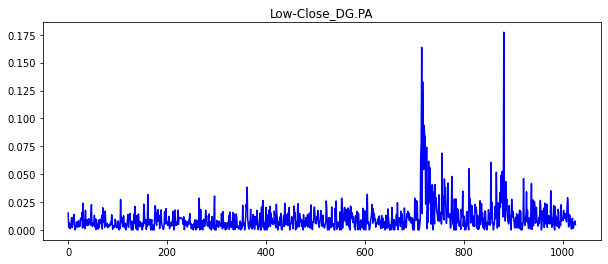

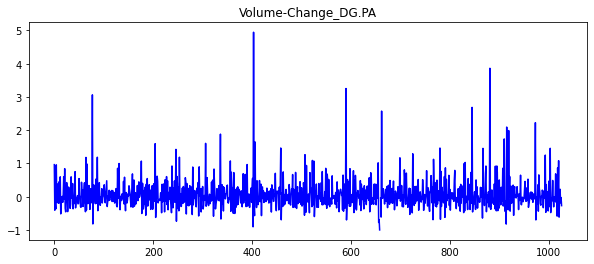

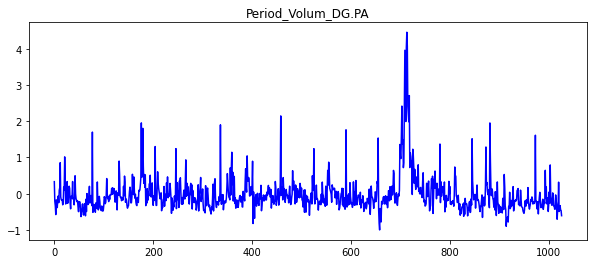

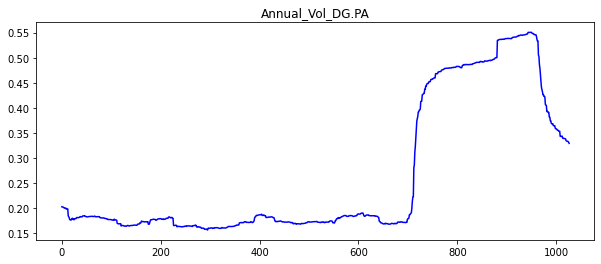

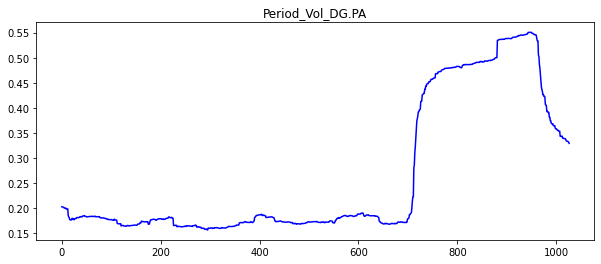

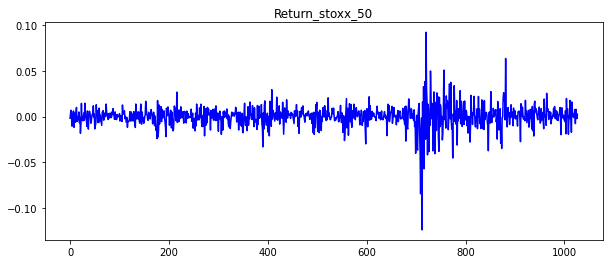

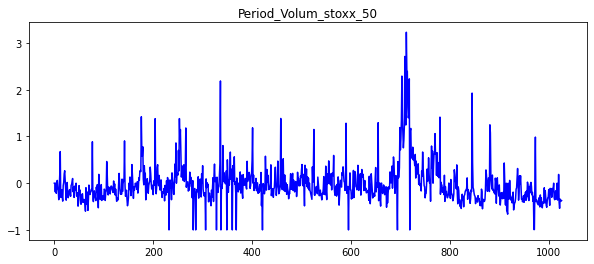

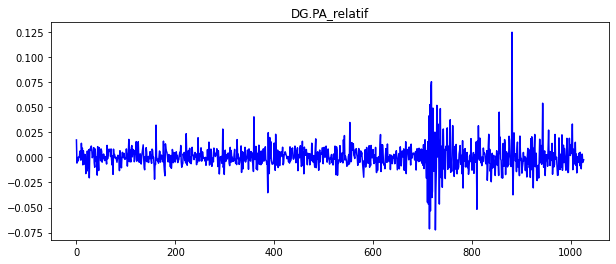

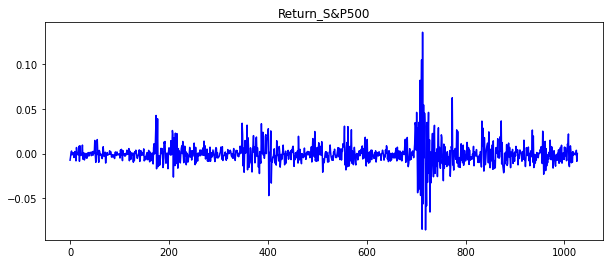

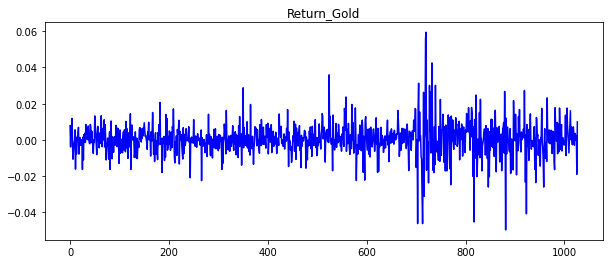

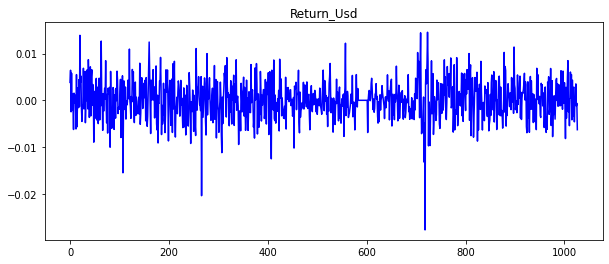

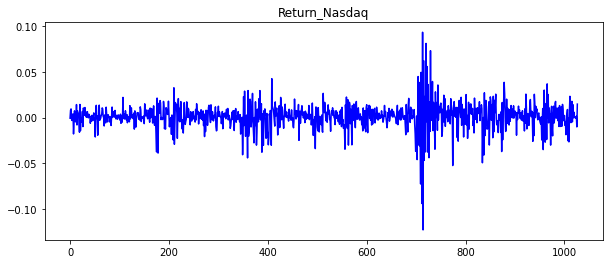

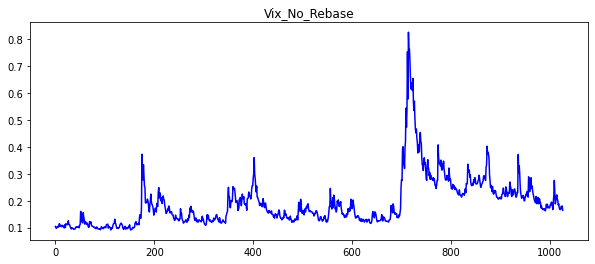

In [6]:
#---Plot the temporal progression of different features of our Data

%matplotlib inline

for col in data.columns:
    color="red" if col == f"Return_{idx}" else "blue"
    data[col].plot(figsize=(10,4), color=color)
    plt.title(col)

    plt.show()

# Data preprocessing TS oriented

## K-folds

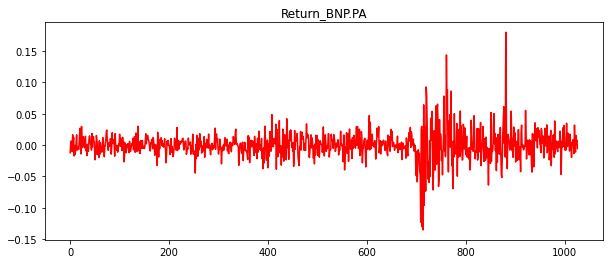

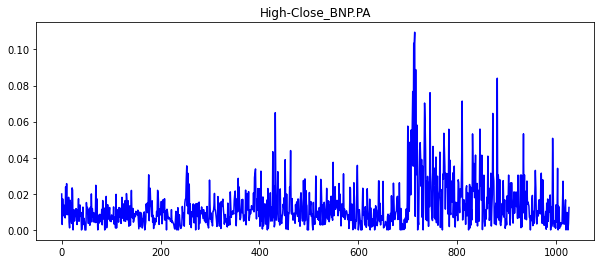

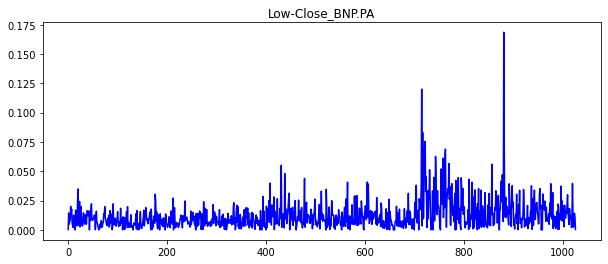

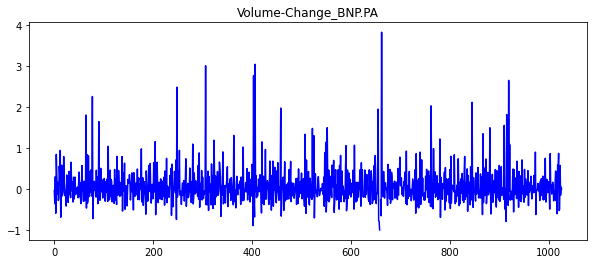

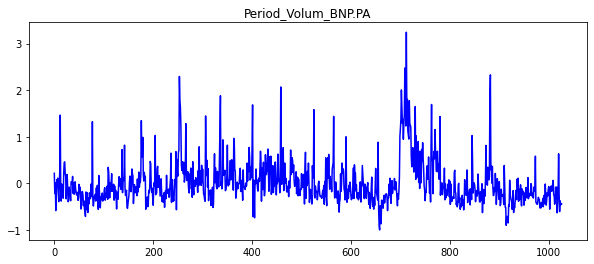

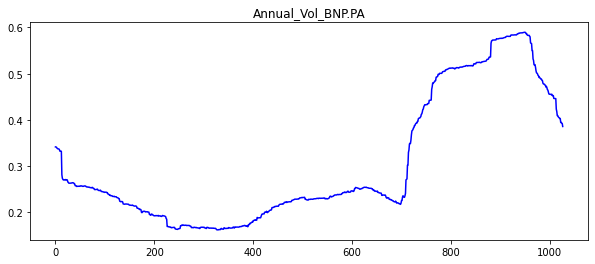

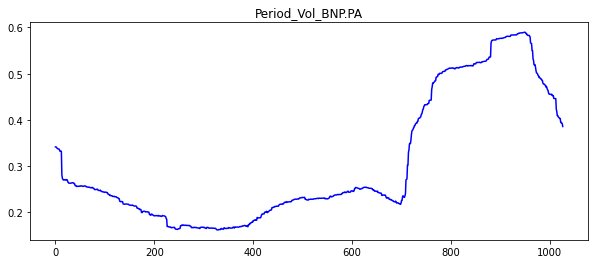

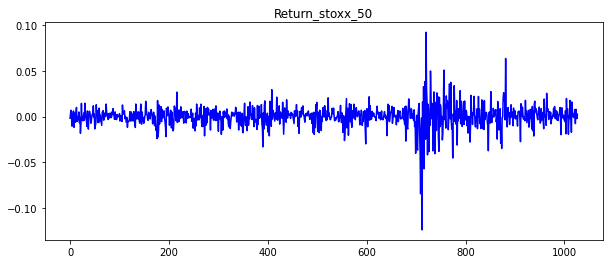

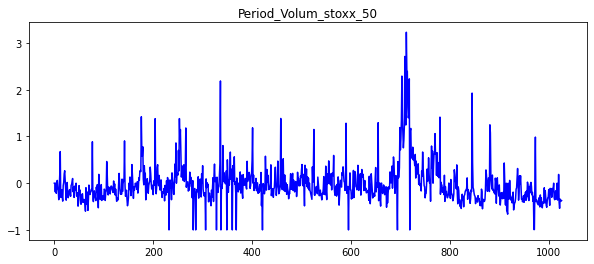

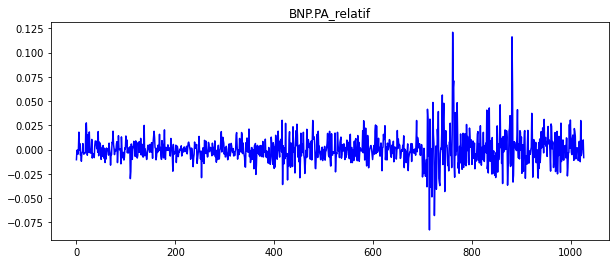

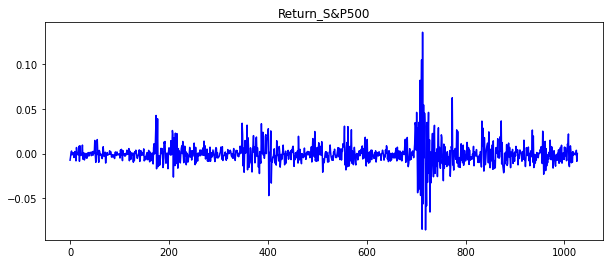

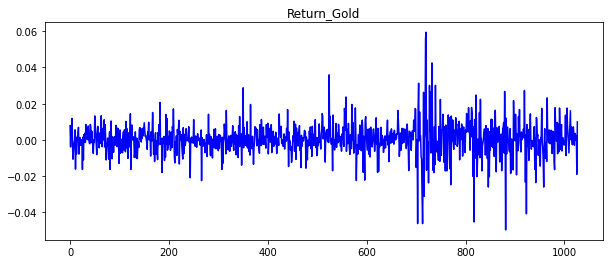

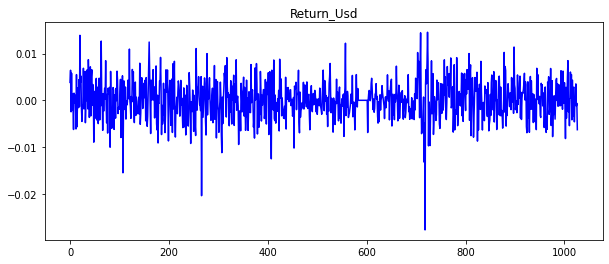

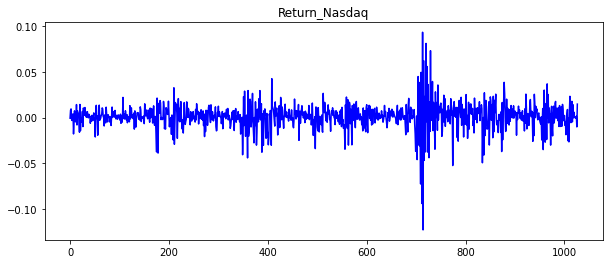

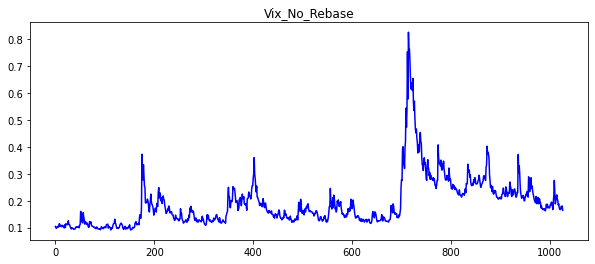

In [31]:
data, idx = load_preproc_data('bnp')
%matplotlib inline

for col in data.columns:
    color="red" if col == f"Return_{idx}" else "blue"
    data[col].plot(figsize=(10,4), color=color)
    plt.title(col)

    plt.show()

<AxesSubplot:>

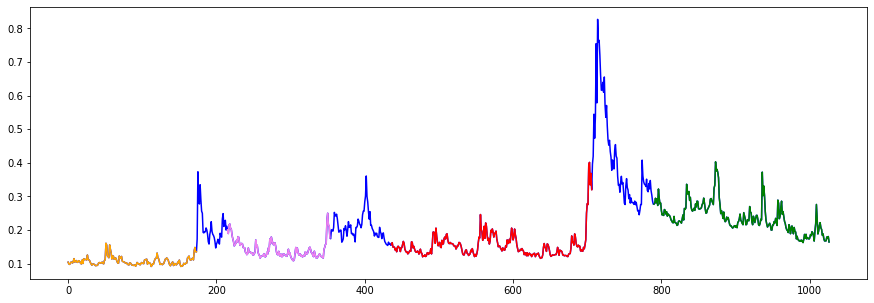

In [32]:
#---Create slices based on 'Vix_no_rebase' (relativité) to train our model on.
data_kfold, idx = load_preproc_data('vinci')

#---Fold_1
data_kfold_1_stop = int(0.17*data.shape[0])
data_kfold_1 = data[:data_kfold_1_stop].copy()

#---Fold_2
data_kfold_2_start = int(0.21*data.shape[0])
data_kfold_2_stop = int(0.345*data.shape[0])
data_kfold_2 = data[data_kfold_2_start:data_kfold_2_stop].copy()

#---Fold_3
data_kfold_3_start = int(0.425*data.shape[0])
data_kfold_3_stop = int(0.6885*data.shape[0])
data_kfold_3 = data[data_kfold_3_start:data_kfold_3_stop].copy()

#---Fold_4
data_kfold_4_start = int(0.77*data.shape[0])
data_kfold_4 = data[data_kfold_4_start:].copy()


#---Plot sample
%matplotlib inline
data_kfold['Vix_No_Rebase'].plot(figsize=(15,5), color='blue')
data_kfold_1['Vix_No_Rebase'].plot(figsize=(15,5), color='orange')
data_kfold_2['Vix_No_Rebase'].plot(figsize=(15,5), color='violet')
data_kfold_3['Vix_No_Rebase'].plot(figsize=(15,5), color='red')
data_kfold_4['Vix_No_Rebase'].plot(figsize=(15,5), color='green')

In [ ]:
#TODO: automatizer la fonction pour qu'elle prenne les sampes
#vérifier qu'il n'y a pas d'écart trop grand entre la moyenne et la variance

In [33]:
def k_fold_split(fold, horizon=1, threshold=0.8):
    
    # gap = 0 here
    gap = horizon - 1

    # set a train: 80%, val: 20% sizes
    train = int(threshold*fold.shape[0])

    fold_train = fold[:train]
    fold_val = fold[train+gap:]
    
    return fold_train, fold_val

In [34]:
def subsample_sequence(df, length=10, horizon=1): #, target = 'DG.PA'
    
    """This function is able to get a subsequence X and a corresponding target y
    N days after the last observationexpressed in horizon variable."""
    
    last_possible = df.shape[0] - length - horizon
    
    random_start = np.random.randint(0, last_possible) #raandom seed  = 0
    
    X = df[random_start: random_start+length].values # drop(columns=[f'Return_{target}']).
    
    # target: Close price to predict
    y = df.iloc[random_start+length+horizon][f'Return_{idx}'] # [f'Return_{target}']; taregt = 'Return'

    return X, y

In [35]:
def get_X_y(df, length=10, horizon=1, number_of_sequences=100):
    
    """This function returns a given number of X and y sequences of given length."""
    
    X, y = [], []

    for _ in range(int(number_of_sequences)):
        
        xi, yi = subsample_sequence(df, length, horizon)
        X.append(xi)
        y.append(yi)
        
    X = np.array(X)
    y = np.array(y)

    return X, y

# Model RNN

In [23]:
data_kfold_1.shape

(174, 15)

In [24]:
data_kfold_2.shape

(139, 15)

In [25]:
data_kfold_3.shape

(271, 15)

In [22]:
data_kfold_4.shape

(237, 15)

In [18]:
# #fold_1
# X_train_1, y_train_1 = get_X_y(fold_train_1, length=10, number_of_sequences=30)
# X_val_1, y_val_1 = get_X_y(fold_val_1, length=10, number_of_sequences=nb_sequences)

# #fold2
# X_train_2, y_train_2 = get_X_y(fold_train_2, length=10, number_of_sequences=30)
# X_val_2, y_val_2 = get_X_y(fold_val_2, length=10, number_of_sequences=nb_sequences)

# #fold3
# X_train_3, y_train_3 = get_X_y(fold_train_3, length=10, number_of_sequences=30)
# X_val_3, y_val_3 = get_X_y(fold_val_3, length=10, number_of_sequences=nb_sequences)

# #fold4
# X_train_4, y_train_4 = get_X_y(fold_train_4, length=10, number_of_sequences=30)
# X_val_4, y_val_4 = get_X_y(fold_val_4, length=10, number_of_sequences=nb_sequences)


In [45]:
def init_model(l_rate = 0.001,
                momentum = 0.9,
                loss = 'MAPE',
                metric = MAPE,
                plot_history=False,
                X_train=None):

    normalizer = Normalization()
    normalizer.adapt(X_train)
    
    #---Initialize the model
    model = Sequential()
    model.add(normalizer)
    model.add(layers.LSTM(30, return_sequences=True, activation='tanh'))
    model.add(layers.LSTM(20, return_sequences=False, activation='tanh'))
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))

    model.compile(loss=loss, 
                  optimizer=RMSprop(learning_rate=l_rate, momentum=momentum), 
                  metrics=[metric])

    return  model

In [37]:
#---Plot train val losses function

def plot_loss(history, patience):
    plt.plot(history.history['loss']) # plot train loss
    plt.plot(history.history['val_loss']) # plot val loss
    plt.title('Loss & Metric')
    plt.ylabel('Mean Absolute Percentage Error')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()
    
    stop_epoch = max(history.epoch)-patience
    val_mape = history.history['val_mean_absolute_percentage_error'][stop_epoch]

    print(f"early stopping at {max(history.epoch)} epoch.\nval_mape: {val_mape}")

In [ ]:
# fold_train_1, fold_val_1 = k_fold_split(data_kfold_1)
# fold_train_2, fold_val_2 = k_fold_split(data_kfold_2)
# fold_train_3, fold_val_3 = k_fold_split(data_kfold_3)
# fold_train_4, fold_val_4 = k_fold_split(data_kfold_4)

In [61]:
data_fold_list_init = [data_kfold_1, data_kfold_2, data_kfold_3, data_kfold_4]

def cross_val(data=None,
              nb_sequences = 10,
              len_ = 5,
              plot_history=False,
             patience=10,
             batch_size=32):

    val_mapeS = []
    mape_baseline=[]

    for data_fold in data_fold_list:

        #---Train and val folds
        fold_train, fold_val= k_fold_split(data_kfold)

        #---Get X_train, y_train, X_val, y_val for a given fold
        X_train, y_train = get_X_y(fold_train, length=len_, number_of_sequences=nb_sequences)
        X_val, y_val = get_X_y(fold_val, length=len_, number_of_sequences=nb_sequences)
        print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

        #---Train model K=4 times per fold 
        model = init_model(X_train=X_train)
        
        es = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

        history = model.fit(X_train, y_train,
                validation_data=(X_val, y_val),
                epochs=1000, 
                batch_size=batch_size,
                callbacks=[es],
                verbose=1)

        stop_epoch = max(history.epoch)-patience
        val_mape = history.history['val_mean_absolute_percentage_error'][stop_epoch]
        
        X_val = []
        y_val = 
        val_mapeS.append(val_mape)
        
        
        if plot_history:

            plot_loss(history, patience)

    mean_val_mape = np.mean(val_mapeS)
    return mean_val_mape

In [62]:
cross_val(data=data_fold_list_init)

(10, 5, 15) (10,) (10, 5, 15) (10,)
Epoch 1/1000
1/1 [==============================] - 6s 6s/step - loss: 1168.1879 - mean_absolute_percentage_error: 1168.1879 - val_loss: 589.4370 - val_mean_absolute_percentage_error: 589.4370
Epoch 2/1000
1/1 [==============================] - 0s 52ms/step - loss: 555.5795 - mean_absolute_percentage_error: 555.5795 - val_loss: 183.7850 - val_mean_absolute_percentage_error: 183.7850
Epoch 3/1000
1/1 [==============================] - 0s 52ms/step - loss: 1193.7921 - mean_absolute_percentage_error: 1193.7921 - val_loss: 162.0279 - val_mean_absolute_percentage_error: 162.0279
Epoch 4/1000
1/1 [==============================] - 0s 56ms/step - loss: 1270.0865 - mean_absolute_percentage_error: 1270.0865 - val_loss: 248.2271 - val_mean_absolute_percentage_error: 248.2271
Epoch 5/1000
1/1 [==============================] - 0s 61ms/step - loss: 963.7489 - mean_absolute_percentage_error: 963.7489 - val_loss: 298.0656 - val_mean_absolute_percentage_error: 298.

Epoch 7/1000
1/1 [==============================] - 0s 55ms/step - loss: 1638.1184 - mean_absolute_percentage_error: 1638.1184 - val_loss: 455.9322 - val_mean_absolute_percentage_error: 455.9322
Epoch 8/1000
1/1 [==============================] - 0s 60ms/step - loss: 1776.2250 - mean_absolute_percentage_error: 1776.2250 - val_loss: 440.0967 - val_mean_absolute_percentage_error: 440.0967
Epoch 9/1000
1/1 [==============================] - 0s 55ms/step - loss: 1317.3284 - mean_absolute_percentage_error: 1317.3284 - val_loss: 553.7249 - val_mean_absolute_percentage_error: 553.7249
Epoch 10/1000
1/1 [==============================] - 0s 74ms/step - loss: 445.2266 - mean_absolute_percentage_error: 445.2266 - val_loss: 720.9109 - val_mean_absolute_percentage_error: 720.9109
Epoch 11/1000
1/1 [==============================] - 0s 55ms/step - loss: 838.1398 - mean_absolute_percentage_error: 838.1398 - val_loss: 762.3405 - val_mean_absolute_percentage_error: 762.3405
Epoch 12/1000
1/1 [========

192.20811462402344

## 30% x 2 + last 20% 

In [55]:
data, idx = load_preproc_data('vinci')

In [57]:
data_1 = data[:int(0.33*data.shape[0])]
data_2 = data[int(0.331*data.shape[0]):int(0.6*data.shape[0])]
data_3 = data[int(0.8*data.shape[0]):]

In [58]:
data_fold_list = [data_1,data_2,data_3]
cross_val(data=data_fold_list)

(10, 10, 15) (10,) (10, 10, 15) (10,)
Epoch 1/1000
1/1 [==============================] - 6s 6s/step - loss: 14808909.0000 - mean_absolute_percentage_error: 14808909.0000 - val_loss: 524.5746 - val_mean_absolute_percentage_error: 524.5746
Epoch 2/1000
1/1 [==============================] - 0s 61ms/step - loss: 5826719.5000 - mean_absolute_percentage_error: 5826719.5000 - val_loss: 969.2230 - val_mean_absolute_percentage_error: 969.2230
Epoch 3/1000
1/1 [==============================] - 0s 68ms/step - loss: 5639381.5000 - mean_absolute_percentage_error: 5639381.5000 - val_loss: 1171.0439 - val_mean_absolute_percentage_error: 1171.0439
Epoch 4/1000
1/1 [==============================] - 0s 69ms/step - loss: 3760294.5000 - mean_absolute_percentage_error: 3760294.5000 - val_loss: 1297.7672 - val_mean_absolute_percentage_error: 1297.7672
Epoch 5/1000
1/1 [==============================] - 0s 67ms/step - loss: 891987.6875 - mean_absolute_percentage_error: 891987.6875 - val_loss: 1372.1632 -

1/1 [==============================] - 0s 60ms/step - loss: 237.0980 - mean_absolute_percentage_error: 237.0980 - val_loss: 95.6035 - val_mean_absolute_percentage_error: 95.6035
Epoch 21/1000
1/1 [==============================] - 0s 61ms/step - loss: 566.9965 - mean_absolute_percentage_error: 566.9965 - val_loss: 87.2201 - val_mean_absolute_percentage_error: 87.2201
Epoch 22/1000
1/1 [==============================] - 0s 58ms/step - loss: 605.2638 - mean_absolute_percentage_error: 605.2638 - val_loss: 90.8201 - val_mean_absolute_percentage_error: 90.8201
Epoch 23/1000
1/1 [==============================] - 0s 65ms/step - loss: 550.3191 - mean_absolute_percentage_error: 550.3191 - val_loss: 97.7434 - val_mean_absolute_percentage_error: 97.7434
Epoch 24/1000
1/1 [==============================] - 0s 59ms/step - loss: 461.3996 - mean_absolute_percentage_error: 461.3996 - val_loss: 103.1535 - val_mean_absolute_percentage_error: 103.1535
Epoch 25/1000
1/1 [==============================] -

449.50548299153644

In [ ]:
cross